In [1]:
# Standard libraries
from collections import Counter

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

## Setup

In [2]:
# Set default colors
orange = '#ff7f0e'
blue = '#1f77b4'
cmap = ListedColormap([blue, orange])

# Set default size for all figures
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 15

In [3]:
# Make initial fake data
X, y = make_classification(
    n_features=2,     # total number of features
    n_redundant=0,    # number of redundant features
    n_informative=2,  # number of informative features
    random_state=42,
    n_clusters_per_class=1
)

In [4]:
def decorate_plot(title):
    plt.title(title)
    plt.xlabel('feature_1')
    plt.ylabel('feature_2')

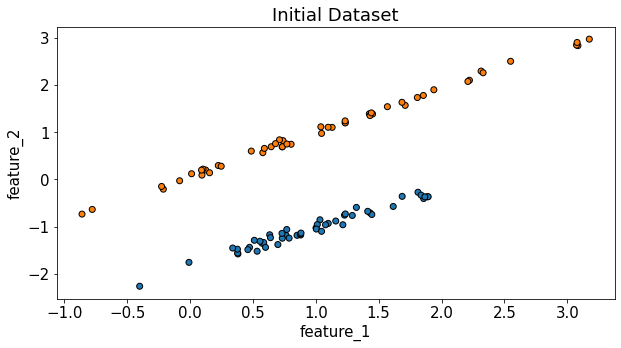

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
decorate_plot('Initial Dataset')

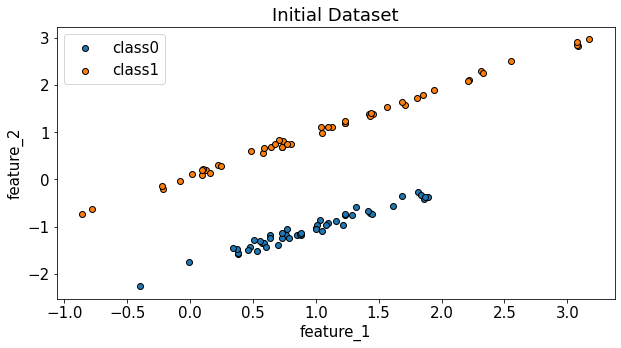

In [6]:
class0_mask = y==0
plt.scatter(X[class0_mask][:,0], X[class0_mask][:,1], color=blue, edgecolor='k', label='class0')
plt.scatter(X[~class0_mask][:,0], X[~class0_mask][:,1], color=orange, edgecolor='k', label='class1')
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

### Add noise
- Don't want to be drastically linearly separable

In [7]:
np.random.seed(42)
noise = 2 * np.random.uniform(size=X.shape)
X += noise

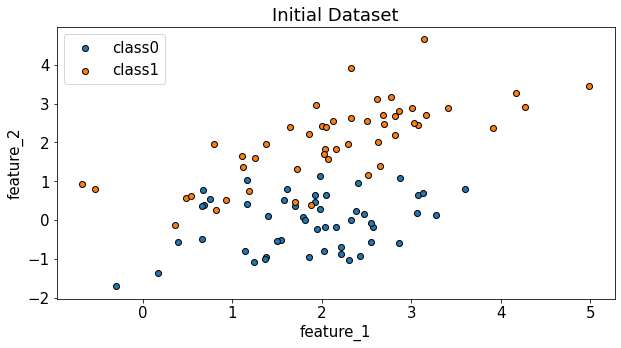

In [8]:
class0_mask = y==0
plt.scatter(X[class0_mask][:,0], X[class0_mask][:,1], color=blue, edgecolor='k', label='class0')
plt.scatter(X[~class0_mask][:,0], X[~class0_mask][:,1], color=orange, edgecolor='k', label='class1')
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

In [9]:
print(X.shape, y.shape)

(100, 2) (100,)


# Problem Statement
We have been given the above data set (called the "Initial Dataset"):
- There are `100` data points each with a `feature_1` attribute and `feature_2` attribute
- Each data point also has a corresponding class associated with it (either `class0` for `y=0` or `class1` for `y=1`)
- We have been tasked with creating a classifier that will take this data and produce a classification as an output. Our goal is the learn the relationship between `feature_1` and `feature_2` that corresponds to the specific class labels we see in the data
  - Or in other words, we want to create a classifier that will take `feature_1` and `feature_2` as inputs and produce either a predicted classification of `class0` (`0`) or `class1` (`1`) as an output
- Since we have these data-point pairs along with their associated class labels, we have *supervised* learning problem

## Classification Algorithm
For the purpose of this demonstration, we will use a simple [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as our classification model
- We will set the maximum depth of the tree to `5` to ensure our model doesn't get overly complex
- This is like saying we want the tree to only be `5` levels deep

In [10]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X,y)
score = clf.score(X,y)
print(score)

0.97


In [11]:
# from sklearn import tree
# tree.plot_tree(clf);

In [12]:
def create_contour_grid(X, clf, grid_step=.02):

    # Pseudo boundaries for gird in plotting
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Complete meshgrid for all datapoints (think "pixels") within plot
    grid_x, grid_y = np.meshgrid(
        np.arange(start=x_min, stop=x_max, step=grid_step),
        np.arange(start=y_min, stop=y_max, step=grid_step)
    )
    
    # Stack all datapoints for prediction
    # np.c_ is like np.column_stack (but faster?)
    stacked_points = np.c_[grid_x.ravel(), grid_y.ravel()]
    
    # Countour height (color label)
    grid_z = clf.predict_proba(stacked_points)[:,1]
    
    # Reshape to mimic xx and yy shape for plotting
    grid_z = grid_z.reshape(grid_x.shape)
    
    return grid_x, grid_y, grid_z


def plot_contour_grid(X, y, grid_x, grid_y, grid_z, title):
    
    # Plot the countour gird (this is the classification algo decision boundary)
    plt.contourf(grid_x, grid_y, grid_z, cmap=cmap)
    
    # Plot the actual data points seen
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
    
    # Plot the accuracy of the classification algo in the upper right of the plot
    plt.text(
        x=grid_x.max() - .05,
        y=grid_y.max() - .6,
        s=f"Acc: {clf.score(X,y):.2f}",
        horizontalalignment='right',
        fontdict={'color':'black', 'fontsize': 15}
    )
    
    decorate_plot(title)

In [13]:
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

0.97

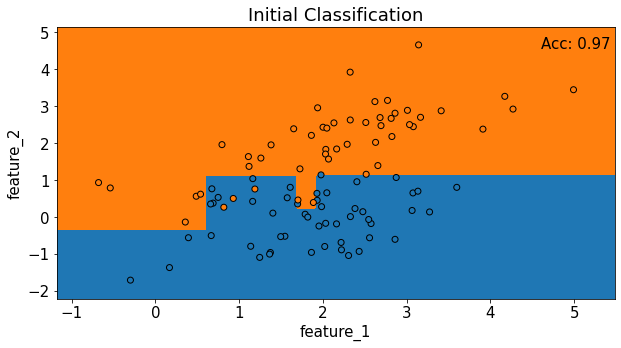

In [14]:
plot_contour_grid(X, y, grid_x, grid_y, grid_z, title='Initial Classification')
clf.score(X, y)

## Discussion
Fantastic! We were able to create a simple classifier (Decision Tree) that has a `97%` accuracy score when applied to the initial dataset. We are feeling pretty good.
- A new batch of data has come through the pipeline
- Let's see how our classifier performs on this second set of data that it has never seen before
- **Note**: we are NOT retraining our classifier, we are applying it to new data
  - This means we should see the same decision boundary when we plot the contour with new data

In [15]:
# Second set of data that our model has never seen
X2, y2 = make_classification(
    n_features=2,     # total number of features
    n_redundant=0,    # number of redundant features
    n_informative=2,  # number of informative features
    random_state=53,
    n_clusters_per_class=1
)

X2 += noise

In [16]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)

0.7

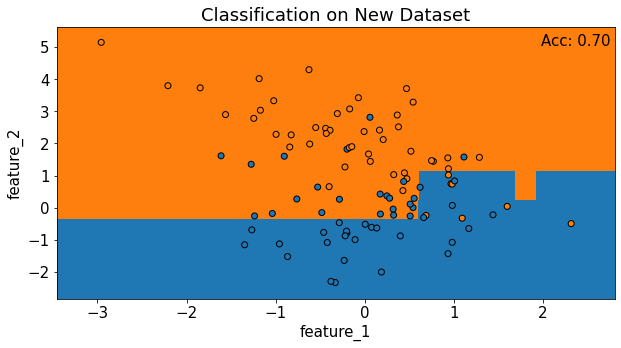

In [17]:
plot_contour_grid(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification on New Dataset')
clf.score(X2, y2)

## Discussion
Uh-oh. What happened here?
- We saw a `97%` accuracy rate when we first trained our model on the initial dataset
- When we applied that same classification model to new data (that the model has never seen), we saw a dramatic degradation in our accuracy
- What is going on?
- Let's look at both the datasets to compare and see if there are dramatic differences

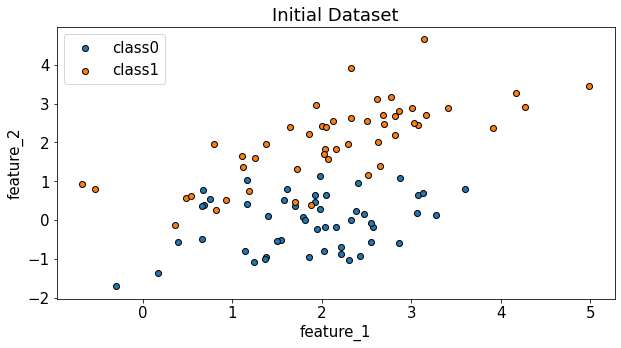

In [18]:
class0_mask = y==0
plt.scatter(X[class0_mask][:,0], X[class0_mask][:,1], color=blue, edgecolor='k', label='class0')
plt.scatter(X[~class0_mask][:,0], X[~class0_mask][:,1], color=orange, edgecolor='k', label='class1')
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

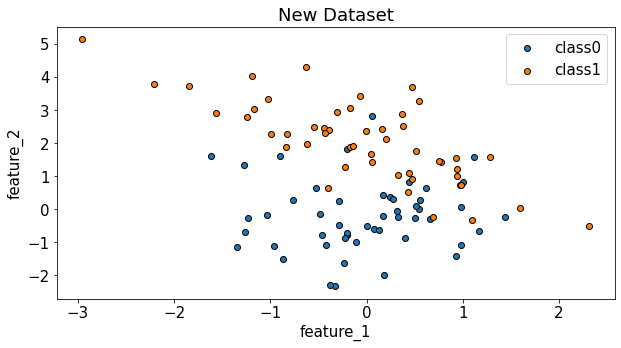

In [19]:
class0_mask2 = y2==0
plt.scatter(X2[class0_mask2][:,0], X2[class0_mask2][:,1], color=blue, edgecolor='k', label='class0')
plt.scatter(X2[~class0_mask2][:,0], X2[~class0_mask2][:,1], color=orange, edgecolor='k', label='class1')
plt.legend(loc='upper right')
decorate_plot('New Dataset')

## Discussion (cont.)
The two datasets seem to be comparable, but do have some differences
- Both datasets seem to be somewhat linearly separable
  - If we drew a line where `feature_2 = 1`, both datasets would seem to be divided into classes
- `class1` in the initial dataset seems to follow a somewhat linearly increasing pattern where in the new data set it seems to follow a somewhat linearly decreasing pattern
- `class0` in the initial dataset seems to be somewhat random in its distribution but falls in the range of `~[0,3]` for `feature_1`. In the new dataset, `class0` is still somewhat random but extends the distribution for `feature_1` to include quite a few values below `0`.

So at the surface, these two datasets differ but not drastically. So why does our classifier behave so poorly on the new dataset?
- It seems like our classifier is behaving well for the initial dataset but that doesn't translate to the new dataset
- In other words, our classifier isn't generalizing well


What we are seeing here is a typical problem encountered in machine learning called **overfitting**
- We have created a classifier that is overfit to our initial dataset
- It has learned the nuances of the initial training dataset so well that it is not robust to other inputs it would see from newly acquired data
- Overfitting occurs when a model learns the details of data it was trained on to the extent that it negatively impacts the performance of the model on new data

## Potential Solution
How do we combat overfitting? We have a few options:
1. We can consider the classification model we are using
  - Typically, a Decision Tree falls victim to overfitting (a disadvantage of using Decstion Trees is their habit of overfitting to their training set)
  - We *could* combat this by using an ensemble of Decision Trees and inject some randomness by selecting a subset of features and samples from the dataset to create an ensemble learner.
  - This is called a Random Forrest model
  - For the purpose of this exercise, we won't explore this option

2. We could re-train our classification model every time we see new data
  - This would require aggregating our initial dataset with any new datasets that come through the pipeline. In essence, we'd be creating a *master* dataset that keeps growing over time
  - We could also just create a new model every time we see new data (but train it specifically and only on the new data)
  - Both of these approaches aren't efficient and would require some heavy-lifting when it comes to maintenance.
  - We'd be creating a new classifier for each batch of data and would have to maintain each of those models in case we had to do retroactive case studies
  - We won't be exploring this option

3. We could create a training and testing dataset based on the initial data and use that to inform decisions on classification model
  - In this scenario, we'd break up our initial training data into `2` datasets (one for model training and one for model evaluation)
  - In this paradigm, a classifier would be trained on a subset of the initial data we were given and tested on a subset of the same data that the model never saw during training
  - This allows us to get a feel for how the model would perform in the "real-world" and make adjustments to the model before deploying it to production
  - Here lies the objective of this presentation, exploring this idea of a training and testing data split

## Train-Test Split
Our goal is too divide our initial dataset into two subsets:
1. A `train` dataset that will be used to train our classification model
2. A `test` dataset that will be used to evaluate the performance of our model on data it has never seen during training
  - The `test` dataset mimics the scenario we have seen in the past
  - We initially trained on **all** of the data we were given and then were surprised to see that our model did not generalize well to new data
  - Instead, we will only use a subset of the data for training and decrease the chances of our model overfitting to our initial dataset
  - We can get a feel for how our model will perform on new data by giving it the `test` dataset and seeing how it performs

## Manual Splitting
We can perform this splitting operation manually in `4` steps:
1. Create an array of indices that corresponds to each datapoint in our initial dataset
2. Shuffle this array of inidices to create a randomized set of indices
3. Slice the array based on a prescribed number of points that are desired to be in the `train` and `test` datasets
  - This is typically a 60-40, 70-30, or 80-20 split for train-test respectively
4. Gather the corresponding datapoints and their class labels based on the slices obtained in step 3

In [20]:
np.random.seed(9)

# Step 1
idx = np.arange(len(X))

# Step 2
np.random.shuffle(idx)

# Step 3
n_train_perc = 0.6
n_train = int(n_train_perc*len(X))
train_idx = idx[:n_train]
test_idx = idx[n_train:]

# Step 4
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 29), (1, 31)]
[(0, 21), (1, 19)]


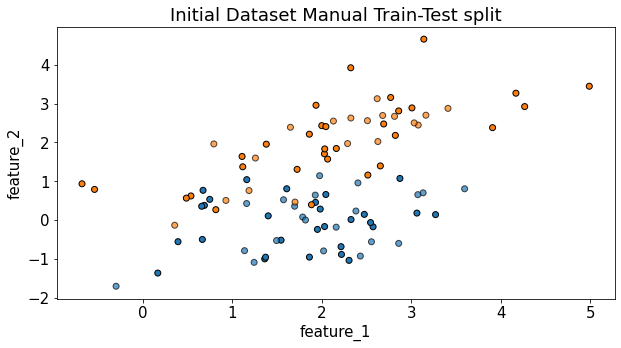

In [21]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap, edgecolors='k', alpha=0.7)
decorate_plot('Initial Dataset Manual Train-Test split')

In [22]:
# Train our classification model only on the training data
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(score)

0.9833333333333333


In [23]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

0.9833333333333333

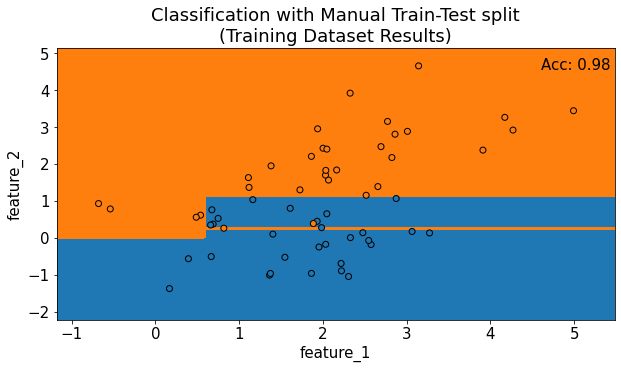

In [24]:
plot_contour_grid(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with Manual Train-Test split\n(Training Dataset Results)'
)

clf.score(X_train, y_train)

0.85

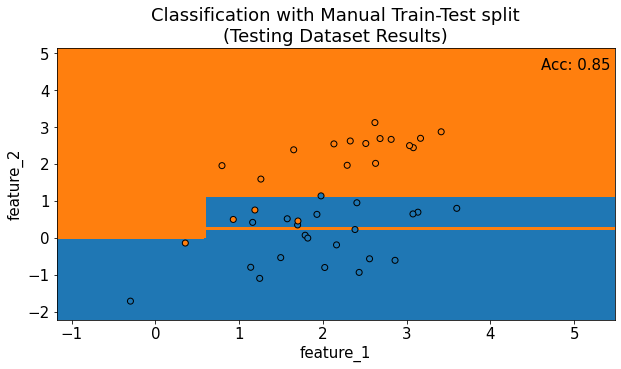

In [25]:
plot_contour_grid(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with Manual Train-Test split\n(Testing Dataset Results)'
)

clf.score(X_test, y_test)

In [26]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)

0.78

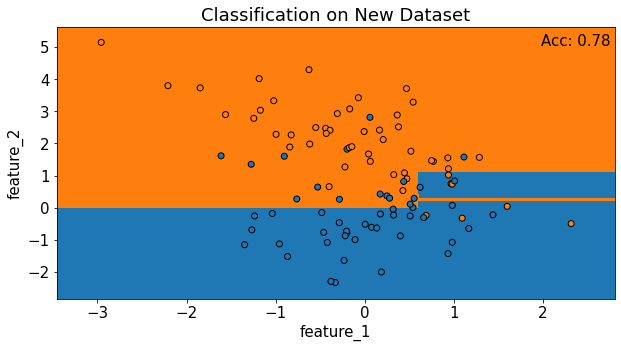

In [27]:
plot_contour_grid(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification on New Dataset')
clf.score(X2, y2)

## Discussion
- Stopped here
- Talk about how we were successful
- Talk about how approach is right but verbose
- Introduce sklearn method
- Talk about stratified
- Talk about cross validation (appendix)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.4,
    random_state=16,
)

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 32, 1: 28})
Counter({1: 22, 0: 18})


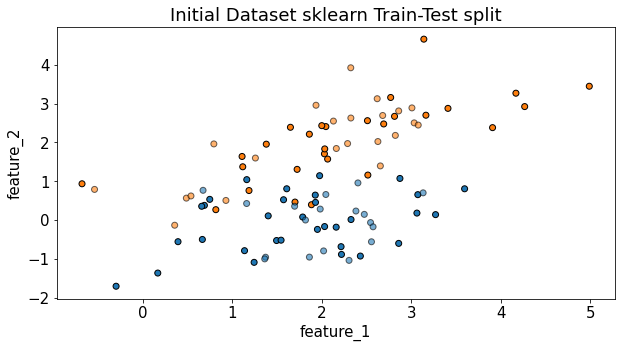

In [29]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap, edgecolors='k', alpha=0.6)
decorate_plot('Initial Dataset sklearn Train-Test split')

In [30]:
# Train our classification model only on the training data
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(score)

0.9666666666666667


In [31]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

0.9666666666666667

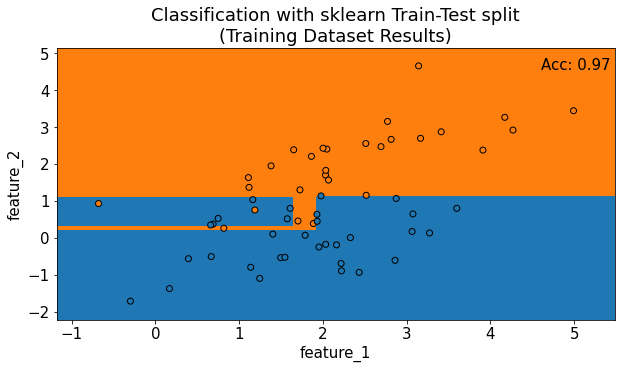

In [32]:
plot_contour_grid(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split\n(Training Dataset Results)'
)

clf.score(X_train, y_train)

0.85

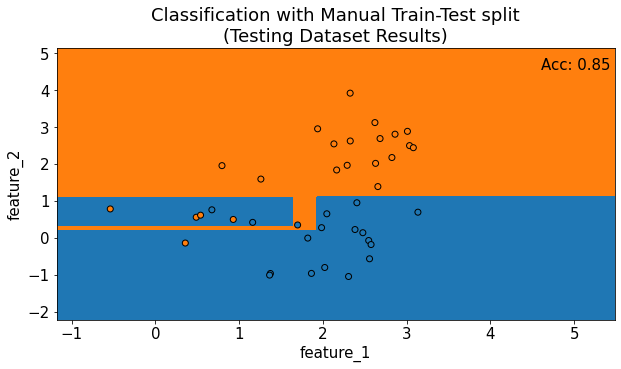

In [33]:
plot_contour_grid(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with Manual Train-Test split\n(Testing Dataset Results)'
)

clf.score(X_test, y_test)

In [34]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)

0.78

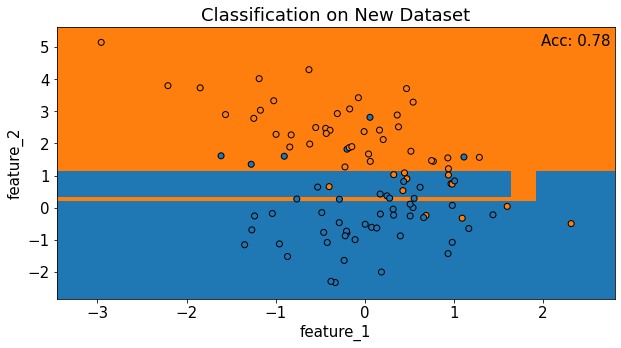

In [35]:
plot_contour_grid(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification on New Dataset')
clf.score(X2, y2)

In [36]:
# Come back to this (stratified)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.4,
    random_state=6,
    stratify=y,
)

In [38]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 30, 1: 30})
Counter({1: 20, 0: 20})


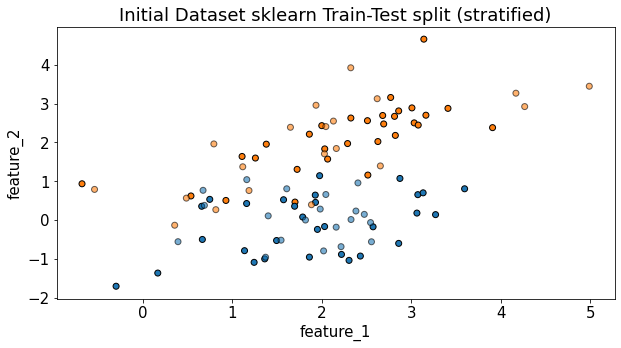

In [39]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap, edgecolors='k')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap, edgecolors='k', alpha=0.6)
decorate_plot('Initial Dataset sklearn Train-Test split (stratified)')

In [40]:
# Train our classification model only on the training data
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(score)

1.0


In [41]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

1.0

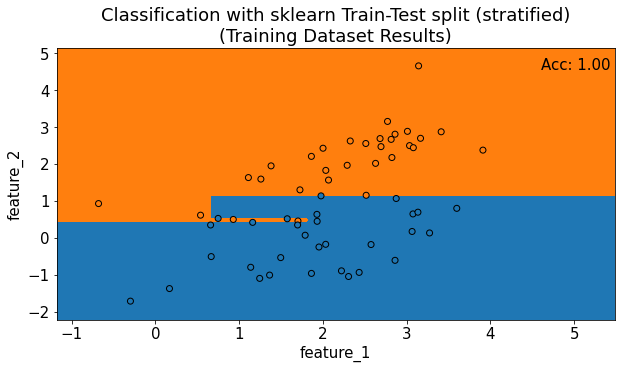

In [42]:
plot_contour_grid(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split (stratified)\n(Training Dataset Results)'
)

clf.score(X_train, y_train)

0.9

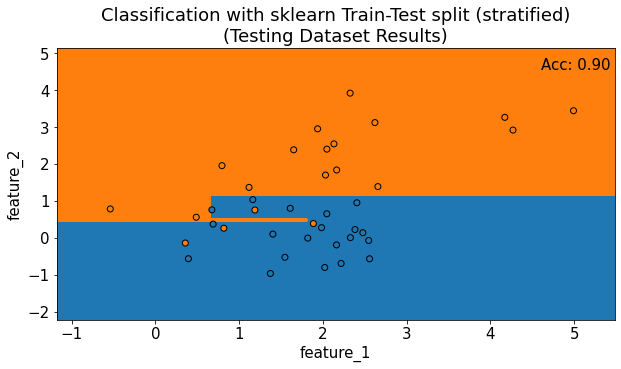

In [43]:
plot_contour_grid(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split (stratified)\n(Testing Dataset Results)'
)

clf.score(X_test, y_test)

In [44]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)

0.84

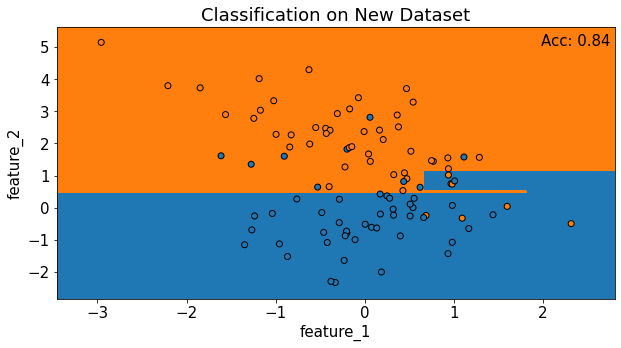

In [45]:
plot_contour_grid(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification on New Dataset')
clf.score(X2, y2)

## Cross Validation

https://www.youtube.com/watch?v=6dbrR-WymjI

Model evaluation procedures
- One of the primary reasons we evaluate ML models is so that we can choose the best available model
- The goal of supervised learning to to build a model that generalizes to out-of-sample data
- Therefore, we want a model evaluation procedure that allows us to estimate how well a given model is likely to perform on out-of-sample data
- We can use this performance estimate to choose between the available models


First idea was to train multiple models on the *entire* dataset and then evaluate each model by testing how well it performs on that same data set (training set it used to train models as well as provided evaluation)
- This produces an evaluation metric known as training accuracy
- Unfortunately, training accuracy rewards overly complex models that are unlikely to generalize to future data (overfitting the training data)

An alternative procedure is called 'train-test-split'
- Here, we split the data into two pieces (partition the data) known as the training and testing sets
- We train the model on the training set
- We evaluate the model by testing its performance on the testing set
- The resulting evaluation metric is known as the testing accuracy which is a better estimate of out-of-sample performance than training accuracy
- This is due to the fact that we trained and tested the model on different sets of data
- Testing accuracy does not reward overly complex models and thus it helps us to avoid overfitting

There are drawbacks to the 'train-test-split' procedure
- It turns out that testing accuracy is a high variance estimate of out-of-sample accuracy
- This means the testing accuracy can change a lot depending on which observations happen to be selected for the testing set
- If we use the training dataset multiple times, over and over to compare and evaluate models, we could start to overfit our test data
  - Could combat this with a train-validation-test split where train dataset is used to train models, validation sets are used to compare models and tweak them and test dataset is used once and only once to evaluate the final model (the test dataset will be used once the model is in its final state and will not be tweaked)


Naturally, you may think that we could solve this problem by creating a bunch of different train-test splits, calculating the testing accuracy each time, and then averaging the results together in order reduce the variance
- This is how cross-validation works
  1. We will split the data into `k` number of partitions of equal size. These partitions are known as folds
  2. We designate the observations in fold 1 as the testing dataset and the union of all other folds as the training data set
  3. We train the model on the training set and we make predictions on the testing set and we calculate the testing accuracy
  4. Now we repeat steps 2 and 3 `k` times using a different fold as the testing set each time
- If `k=5`, we'd repeat this process `5` times
- Finally, the average testing accuracy also known as the cross validated accuracy is used as the estimate of out-of-sample accuracy


https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
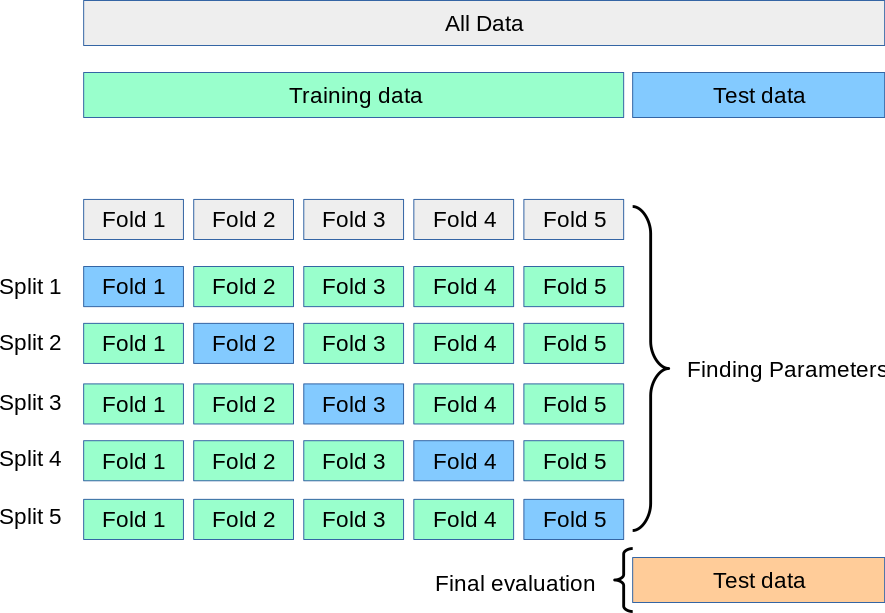

>To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

> However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). **A test set should still be held out for final evaluation**, but *the validation set* is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using  of the folds as training data;

- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

## Cross Validation cont.
The main reason we prefer cross validation to 'train-test-split' is that cross validation generates a more accurate estimate of out-of-sample accuracy which is what we need in order to choose the best model
- CV also uses the data more efficiently than 'train-test-split' since every observation is used for both training and testing the model
- Two primary advantages to using 'train-test-split' instead of CV
- First, train-test split runs k times faster than k-fold CV since k-fold CV essentially repeats the train-test split process `k` times
  - This is an important consideration for larger data sets as well as models that take a long time to train
- Second, it is much easier to examine the detailed results of the testing process from 'train-test-split'
  - sklearn makes CV easy to implement, but all we get back are resulting scores
  - This makes it difficult to inspect the results using a confusion matrix of ROC curve
  - 'train-test-split' makes it easy to examine those results
  
  
## CV recommendations
- `k=10` is generally recommended because it has been shown experimentally to produce the most reliable estimates of out-of-sample accuracy
- When using cross-validation with classification problems it is recommended that you use stratified sampling to create the folds
  - This means that each response class should be represented with approximately equal proportions in each of the folds
  - For example, if your dataset has `2` response classes (`ham` and `spam`) and 20% of your observations were `ham`, then each of your cross validation folds should consist of approximately 20% `ham`
  - Thankfully, sklearn uses stratified sampling by default when using the `cross_val_score()` function

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


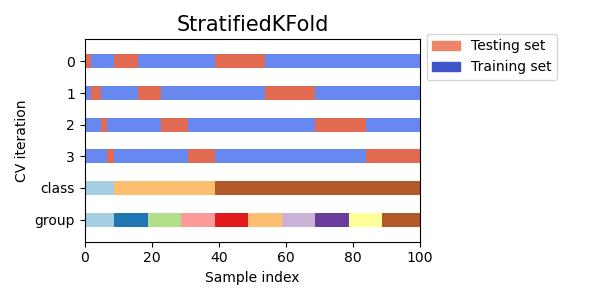

## Improvements to CV
- Repeated CV
  - k-fold CV is repeated multiple times with different random splits of the data in to k folds and results are averages
  - Provides a more reliable estimate of out-of-sample performance by reducing the variance associated with *a single* trial of cross-validation
- Create a hold-out set
  - Instead of running CV on the entire dataset a portion of the data is held out and not touched during the model building process
  - The best model is located and tuned using CV on the training data (i.e. not the hold out set)
  - At the end of this process, the hold out set is then used to "test" the best model
  - The performance on this holdout set is considered to be a more reliable estimate of out-of-sample performance than the CV performance since the hold out set is completely out-of-sample for the entire CV process

In [46]:
# split into training (used for CV) and testing (final eval)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80, 2) (80,)
(20, 2) (20,)


In [47]:
def summarize_clf(clf, X_train, y_train, X_test, y_test, X2, y2):
    
    # 5-fold cross-validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Scores                  : {scores}")
    
    # use average accuracy as an estimate of out-of-sample accuracy
    print(f"Cross-Validated Accuracy: {scores.mean()} (+- {scores.std()*2:.3f})")
    
    clf.fit(X_train, y_train)
    print(f"Train Accuracy          : {clf.score(X_train, y_train)}")
    print(f"Test Accuracy           : {clf.score(X_test, y_test)}")
    print(f"New data Accuracy       : {clf.score(X2, y2)}")

In [48]:
seed=5

In [49]:
# No change here, just for reference
dt = DecisionTreeClassifier(max_depth=5, random_state=seed)
summarize_clf(dt, X_train, y_train, X_test, y_test, X2, y2)

Scores                  : [0.875 1.    0.75  0.875 1.   ]
Cross-Validated Accuracy: 0.9 (+- 0.187)
Train Accuracy          : 0.9875
Test Accuracy           : 0.8
New data Accuracy       : 0.7


In [50]:
# The maximum depth of the tree.
# If None, then nodes are expanded until all leaves are pure or until all leaves contain less than
# min_samples_split samples.
dt2 = DecisionTreeClassifier(random_state=seed)
summarize_clf(dt2, X_train, y_train, X_test, y_test, X2, y2)

Scores                  : [0.9375 1.     0.75   0.875  1.    ]
Cross-Validated Accuracy: 0.9125 (+- 0.187)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.71


In [51]:
rf = RandomForestClassifier(n_estimators=25, random_state=seed)
summarize_clf(rf, X_train, y_train, X_test, y_test, X2, y2)

Scores                  : [0.875  0.9375 0.875  0.875  0.9375]
Cross-Validated Accuracy: 0.9 (+- 0.061)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.74


In [52]:
rf2 = RandomForestClassifier(random_state=seed)
summarize_clf(rf2, X_train, y_train, X_test, y_test, X2, y2)

Scores                  : [0.9375 1.     0.875  0.875  1.    ]
Cross-Validated Accuracy: 0.9375 (+- 0.112)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.77


https://www.datarobot.com/wiki/training-validation-holdout/
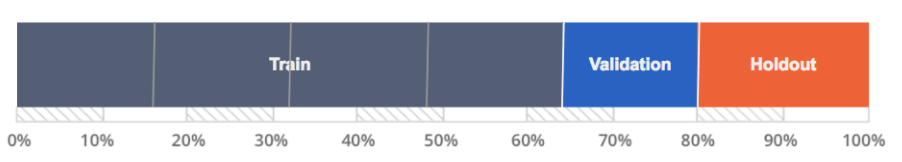

The purpose of cross-validation is not to come up with our final model. We don't use these 5 instances (5-fold CV) of our trained model to do any real predictions in this case.
- The purpose of CV is model *checking* not model *building*
- Say we have two models, say a linear regression model and a neural network. How can we say which model is better? We can do K-fold cross-validation and see which one proves better at predicting the test set points. But once we have used cross-validation to select the better performing model, we train that model (whether it be the linear regression or the neural network) on all the data (training data used for CV). We don't use the actual model instances we trained during cross-validation for our final predictive model.